# Final project AH2179: Public transport arrival delay prediction

Jiani She, jianis@kth.se <br>
Thomas Bartholomeus Koning, tbkoning@kth.se


## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


## Import data

In [2]:
df = pd.read_csv('Dataset-PT.csv', header = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545103 entries, 0 to 545102
Data columns (total 31 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Calendar_date                      545103 non-null  int64  
 1   route_id                           545103 non-null  int64  
 2   bus_id                             545103 non-null  int64  
 3   stop_sequence                      545103 non-null  int64  
 4   arrival_delay                      545103 non-null  int64  
 5   dwell_time                         545103 non-null  int64  
 6   travel_time_for_previous_section   545103 non-null  int64  
 7   scheduled_travel_time              545103 non-null  int64  
 8   upstream_stop_delay                545103 non-null  int64  
 9   origin_delay                       545103 non-null  int64  
 10  previous_bus_delay                 545103 non-null  int64  
 11  previous_trip_travel_time          5451

The dataset is imported. The header parameter is set to 1, because the first line of the .csv file contains the titles. The results of the .info() line shows that the dataset consists of 31 columns and 545103 lines. None of the lines contains empty cells. Most columns in the dataset contains integers. The traffic condition and recurrent delay are continous value. Lastly, the weather, temperature, day of the week and time of the day columns consist of categorical data.

## Step 1: Data pre-processing

This step is all about discovering the dataset and preparing this dataset for the analysis in teh next steps.

### Step 1.1: Descriptive data analysis

In the next cells we will first look at the first 10 rows of the dataset to get a general picture of what the dataset looks like. In the cell afterwards we will specifically look at the unique values in the 4 categorical columns (weather, temperature, day_of_week and time_of_day): 

In [3]:
df.head(10)

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1
5,20220108,4,41344,6,260,13,105,38,242,100,...,0,0,0,0,1,0,1,0,0,1
6,20220108,4,41344,7,278,12,43,79,260,100,...,0,0,0,0,1,0,1,0,0,1
7,20220108,4,41344,8,272,8,85,97,278,100,...,0,0,0,0,1,0,1,0,0,1
8,20220108,4,41344,9,292,24,83,47,272,100,...,0,0,0,0,1,0,1,0,0,1
9,20220108,4,41344,10,351,9,43,85,292,100,...,0,0,0,0,1,0,1,0,0,1


In [4]:
print("Objects in weather column: ", df["weather"].unique())
print("Objects in temperature column: ", df["temperature"].unique())
print("Objects in day_of_week column: ", df["day_of_week"].unique())
print("Objects in time_of_day column: ", df["time_of_day"].unique())

Objects in weather column:  ['Light Snow' 'Normal' 'Light Rain' 'Rain' 'Snow']
Objects in temperature column:  ['Normal' 'Cold' 'Extra cold']
Objects in day_of_week column:  ['weekend' 'weekday']
Objects in time_of_day column:  ['OP' 'MP' 'AP']


The found elements in the object columns correspond to the last 13 columns of the dataset. Based on this, we can conclude that one-hot encoding was applied to the 4 object columns.

The next step is to get more insights in the data in the data in each column. In the first following cell we will find basic summary statistics of each column in DataFrame. For the sake of readibility of teh results, df.descirbe() function is split up in two cells. The cells afterwards, we will zoom in on specific columns:

In [5]:
df[["Calendar_date", "route_id", "bus_id", "stop_sequence", "arrival_delay", "dwell_time", 
             "travel_time_for_previous_section", "scheduled_travel_time", "upstream_stop_delay", 
             "origin_delay", "previous_bus_delay", "previous_trip_travel_time", "traffic_condition",
             "recurrent_delay"]].describe()

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,previous_trip_travel_time,traffic_condition,recurrent_delay
count,5.451030e+05,545103.0,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000
mean,2.022036e+07,4.0,42960.801278,14.000000,134.972238,31.994665,71.440968,105.918404,135.651912,75.107237,134.379284,73.183840,73.154933,72.750008
std,1.600773e+02,0.0,1707.986641,7.788888,193.899487,27.215700,37.590646,36.420995,190.271573,133.625958,193.635484,35.678285,32.321151,29.590991
min,2.022011e+07,4.0,41343.000000,1.000000,-3493.000000,0.000000,0.000000,38.000000,-3403.000000,-3061.000000,-3493.000000,-2.000000,18.333333,27.750000
25%,2.022022e+07,4.0,41364.000000,7.000000,11.000000,17.000000,45.000000,75.000000,14.000000,15.000000,11.000000,46.000000,47.666667,48.627737
50%,2.022033e+07,4.0,41731.000000,14.000000,88.000000,25.000000,64.000000,104.000000,86.000000,27.000000,88.000000,64.000000,65.000000,64.614679
75%,2.022051e+07,4.0,44413.000000,21.000000,209.000000,41.000000,93.000000,129.000000,206.000000,68.000000,208.000000,93.000000,93.000000,91.542857
max,2.022063e+07,4.0,45808.000000,27.000000,2257.000000,1616.000000,1069.000000,198.000000,2257.000000,1812.000000,2230.000000,1069.000000,732.666667,211.916667


In [6]:
df[["factor(weather)Light_Rain", "factor(weather)Light_Snow", "factor(weather)Normal",
   "factor(weather)Rain", "factor(weather)Snow", "factor(temperature)Cold",
   "factor(temperature)Extra_cold", "factor(temperature)Normal", "factor(day_of_week)weekday",
   "factor(day_of_week)weekend", "factor(time_of_day)Afternoon_peak", "factor(time_of_day)Morning_peak",
   "factor(time_of_day)Off-peak"]].describe()

,factor(weather)Light_Rain,factor(weather)Light_Snow,factor(weather)Normal,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
count,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000,545103.000000
mean,0.024469,0.017831,0.944722,0.006191,0.006786,0.112735,0.017931,0.869335,0.767101,0.232899,0.208678,0.164892,0.626430
std,0.154499,0.132339,0.228522,0.078442,0.082097,0.316268,0.132699,0.337034,0.422679,0.422679,0.406364,0.371083,0.483752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# Plot the number of data points per day!


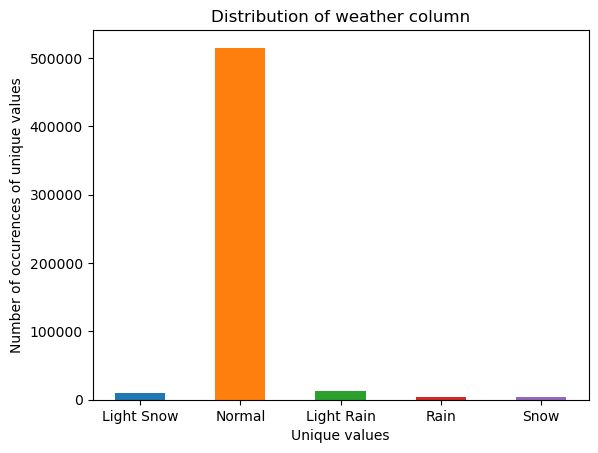

In [8]:
# Distribution of the wheather column:
for i in df["weather"].unique():
    count = df["weather"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of weather column")
plt.show()

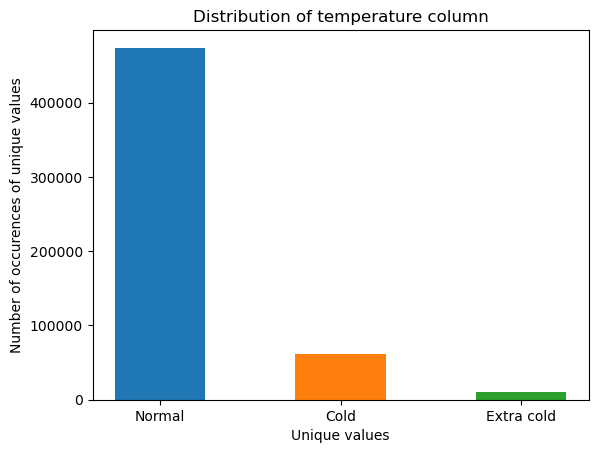

In [9]:
# Distribution of the temperature column:
for i in df["temperature"].unique():
    count = df["temperature"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of temperature column")
plt.show()

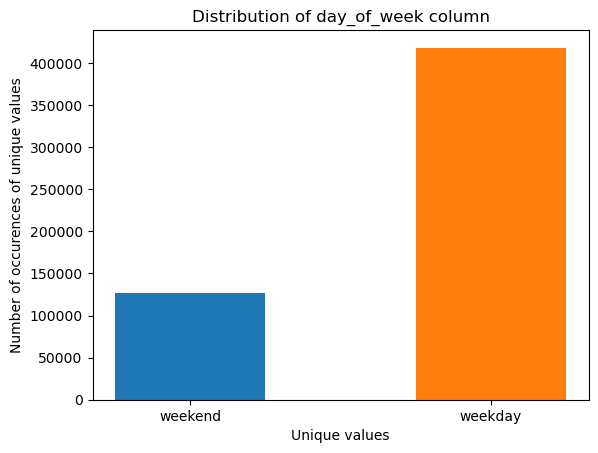

In [10]:
# Distribution of the day_of_week column:
for i in df["day_of_week"].unique():
    count = df["day_of_week"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of day_of_week column")
plt.show()

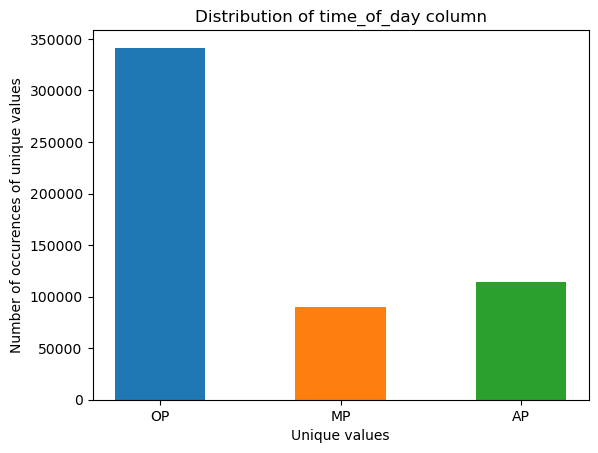

In [11]:
# Distribution of the time_of_day column:
for i in df["time_of_day"].unique():
    count = df["time_of_day"].value_counts()[i]
    plt.bar(i, count, width = 0.5)
    plt.xlabel("Unique values")
    plt.ylabel("Number of occurences of unique values")
    plt.title("Distribution of time_of_day column")
plt.show()

The last for 4 plots clearly show that the data is not evenly distributed in the 4 object columns in the data set. We see in the weather column for example that there are much more days with normal weather, than that there rainy or snowy days. We see the same pattern in the temperature column, which contains much more often normal as value than cold or extra cold. In the weekday bar chart we see a pattern that was to be expected, approximately 3 times as many weekdays as there are weekenddays in the dataset. Lastly for the time of day column we have much more OP (off-peak) values than that we have MP (morning peak) or AF (afternoon peak) values.
In conclusion, the object columns, and therefore also the one-hot encoding columns made based on these columns, are fairly imbalanced. An imbalanced data set is a problem for training machine learning models, including training regression models. We will deal with this issue in section 1.2. 

It is also important to consider the relationship between the columns in the data set, for example with a correlation matrix, heatmap of the correlation matrix and a SNS plot:

In [18]:
#df_correlation = df[["Calendar_date", "route_id", "bus_id", "stop_sequence", "arrival_delay", "dwell_time", 
#             "travel_time_for_previous_section", "scheduled_travel_time", "upstream_stop_delay", 
#             "origin_delay", "previous_bus_delay", "previous_trip_travel_time", "traffic_condition",
#             "recurrent_delay", "factor(weather)Light_Rain", "factor(weather)Light_Snow", "factor(weather)Normal", 
#                    "factor(weather)Rain", "factor(weather)Snow", "factor(temperature)Cold", 
#                    "factor(temperature)Extra_cold", "factor(temperature)Normal", "factor(day_of_week)weekday", 
#                    "factor(day_of_week)weekend", "factor(time_of_day)Afternoon_peak", "factor(time_of_day)Morning_peak",
#                    "factor(time_of_day)Off-peak"]]
df_correlation = df.drop(["Calendar_date", "route_id", "bus_id", "stop_sequence", "weather", "temperature", 
                          "day_of_week","time_of_day"], axis=1)
#df_correlation.info()
df_correlation.corr()


#print("Objects in weather column: ", df["weather"].unique())
#print("Objects in temperature column: ", df["temperature"].unique())
#print("Objects in day_of_week column: ", df["day_of_week"].unique())
#print("Objects in time_of_day column: ", df["time_of_day"].unique())

,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,previous_trip_travel_time,traffic_condition,recurrent_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
arrival_delay,1.000000,0.089433,0.081113,-0.142228,0.975019,0.716324,0.265434,-0.036870,-0.043104,-0.069122,...,0.010833,-0.001579,-0.013595,-0.024602,0.022444,-0.190783,0.190783,-0.091946,-0.079354,0.138109
dwell_time,0.089433,1.000000,0.314884,-0.091127,-0.064040,-0.007937,-0.017797,-0.013858,-0.016354,-0.020866,...,-0.005352,0.002198,-0.025249,-0.022725,0.032641,0.074188,-0.074188,0.050924,0.015988,-0.055041
travel_time_for_previous_section,0.081113,0.314884,1.000000,-0.262382,0.030967,0.012168,0.047280,-0.243823,-0.269617,-0.293594,...,-0.001887,0.002113,0.006813,-0.007542,-0.003423,0.073016,-0.073016,0.046240,0.038868,-0.068658
scheduled_travel_time,-0.142228,-0.091127,-0.262382,1.000000,-0.056838,0.005330,-0.136826,0.617814,0.681883,0.727653,...,-0.007432,0.002066,-0.017197,-0.025146,0.026038,0.165351,-0.165351,0.129195,0.054297,-0.150178
upstream_stop_delay,0.975019,-0.064040,0.030967,-0.056838,1.000000,0.729940,0.250198,-0.055600,-0.062058,-0.084258,...,0.010717,-0.001929,-0.014920,-0.025108,0.023887,-0.188221,0.188221,-0.085657,-0.080449,0.133667
origin_delay,0.716324,-0.007937,0.012168,0.005330,0.729940,1.000000,0.169857,0.012691,0.014888,-0.001412,...,0.003060,-0.006193,-0.049544,-0.039400,0.062004,-0.140618,0.140618,0.000716,-0.107589,0.081929
previous_bus_delay,0.265434,-0.017797,0.047280,-0.136826,0.250198,0.169857,1.000000,0.022439,-0.019429,-0.066933,...,0.014108,-0.000504,-0.013715,-0.022832,0.021860,-0.189343,0.189343,-0.088458,-0.079253,0.135101
previous_trip_travel_time,-0.036870,-0.013858,-0.243823,0.617814,-0.055600,0.012691,0.022439,1.000000,0.904514,0.832534,...,-0.002225,0.002627,0.006155,-0.007665,-0.002758,0.078855,-0.078855,0.053918,0.033343,-0.070869
traffic_condition,-0.043104,-0.016354,-0.269617,0.681883,-0.062058,0.014888,-0.019429,0.904514,1.000000,0.917853,...,-0.002825,0.003911,0.005919,-0.008552,-0.002188,0.087818,-0.087818,0.062773,0.030604,-0.076207
recurrent_delay,-0.069122,-0.020866,-0.293594,0.727653,-0.084258,-0.001412,-0.066933,0.832534,0.917853,1.000000,...,-0.004160,0.000820,-0.002599,-0.011106,0.006812,0.085398,-0.085398,0.059799,0.039054,-0.080191


<Axes: >

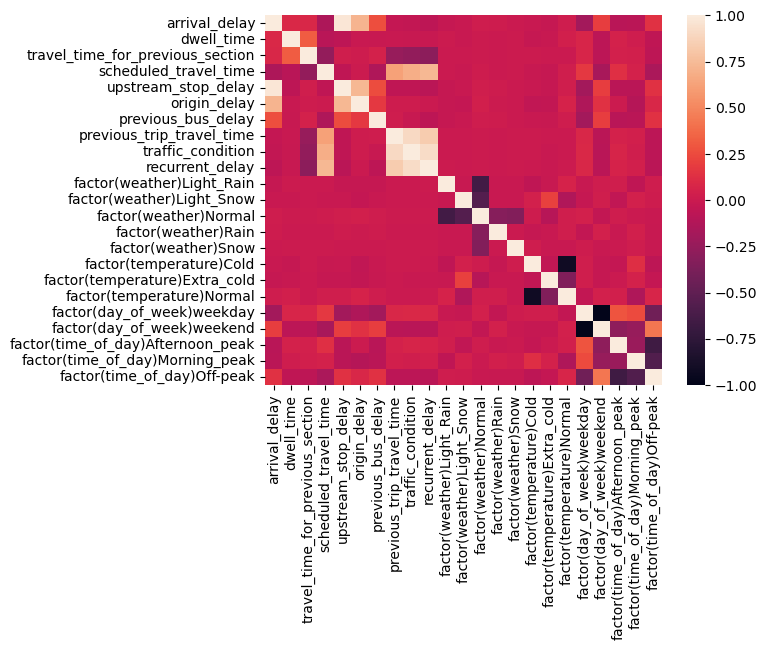

In [20]:
sns.heatmap(df_correlation.corr(), annot=False)

When analyzing the correlation matrix and the heatmap we see several patterns occuring:
The arrival delay (target value for the analysis in this research) is mainly correlated with 

### Step 1.2: Data pre-processing

In [14]:
# Drop the 4 object columns: ["weather", "temperature", "day_of_week", "time_of_day"]
# Delete outliers from the dataset (wrong values) --> e.g. see minimum value of arrival delay column!
# Add column with specific day of the week (1-7)
# Create a seperate dataframe for each busstop in the dataset, with only the data on the previous stops in it?
# Handle imbalanced dataset! --> under or over sampling?


### Step 1.3: Feature engineering

### Step 1.4: Exploratory data analysis

## Step 2: Train-test split

## Step 3: Training the models

### Step 3.1-3.3: 5-fold cross validation, training the models and finding the best parameter combinations

In [15]:
# Linear regression
# Decision trees
# Random forest
# XGBoost
# Support Vector Machine
# Neural network

### Step 3.4: Train the models on the full training set

## Step 4: Testing the models

### Step 4.1: Make predictions with the models

### Step 4.2: Evaluate model performance

### Step 4.3: Select best model

## Step 5: Final model

### Step 5.1: Train the final model

### Step 5.2: Save the final model